In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
df = pd.read_parquet('gt2011-gt2015.parquet')

In [3]:
df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,Datetime
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952,2011-01-01 00:00:00
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377,2011-01-01 01:10:55
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776,2011-01-01 02:21:50
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505,2011-01-01 03:32:45
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028,2011-01-01 04:43:40
...,...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,89.172,2015-12-31 18:21:49
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,88.849,2015-12-31 19:33:00
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,96.147,2015-12-31 20:44:11
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,64.738,2015-12-31 21:55:22


In [4]:
df.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000
mean,17.712726,1013.070165,77.867015,3.925518,25.563801,1081.428084,546.158517,133.506404,12.060525,2.372468,65.293067
std,7.447451,6.463346,14.461355,0.773936,4.195957,17.536373,6.842360,15.618634,1.088795,2.262672,11.678357
min,-6.234800,985.850000,24.085000,2.087400,17.698000,1000.800000,511.040000,100.020000,9.851800,0.000388,25.905000
25%,11.781000,1008.800000,68.188000,3.355600,23.129000,1071.800000,544.720000,124.450000,11.435000,1.182400,57.162000
50%,17.801000,1012.600000,80.470000,3.937700,25.104000,1085.900000,549.880000,133.730000,11.965000,1.713500,63.849000
75%,23.665000,1017.000000,89.376000,4.376900,29.061000,1097.000000,550.040000,144.080000,12.855000,2.842900,71.548000
max,37.103000,1036.600000,100.200000,7.610600,40.716000,1100.900000,550.610000,179.500000,15.159000,44.103000,119.910000


<AxesSubplot:xlabel='NOX', ylabel='Count'>

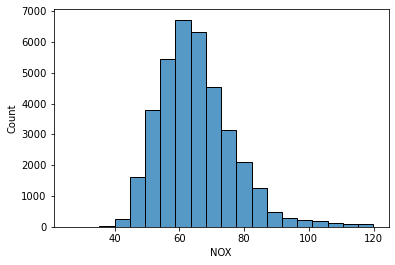

In [5]:
sns.histplot(df, x='NOX', bins=20)

<AxesSubplot:xlabel='CO', ylabel='Count'>

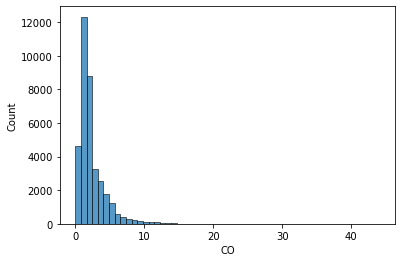

In [6]:
sns.histplot(df, x='CO', bins=54)

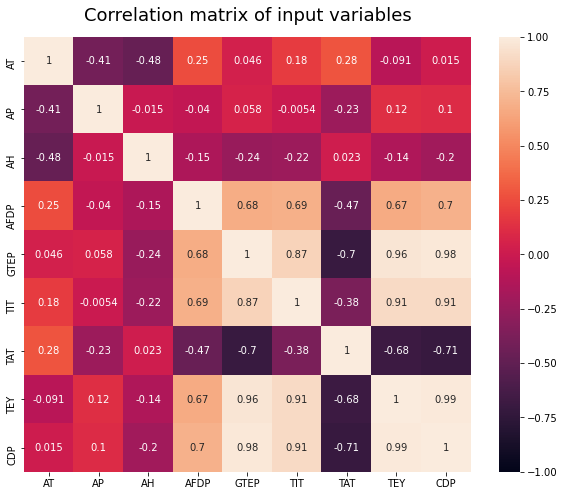

In [7]:

plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(df.drop(columns=['CO','NOX']).corr()))

heatmap = sns.heatmap(df.drop(columns=['CO','NOX']).corr(),  vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation matrix of input variables', fontdict={'fontsize':18}, pad=16);

In [8]:
CO_list = []
NOX_list = []

for column in df.columns[:-2]:
    CO_list.append(df['CO'].corr(df[column]))
    NOX_list.append(df['NOX'].corr(df[column]))
corr_df = pd.DataFrame({'CO': CO_list, 'NOX': NOX_list},index=df.columns[:-2])    


cm = sns.light_palette("green", as_cmap=True)

display(((corr_df).round(3)).style.background_gradient(cmap="PiYG",axis=None).format("{:3}"))

,CO,NOX
AT,-0.174,-0.558
AP,0.067,0.192
AH,0.107,0.165
AFDP,-0.448,-0.188
GTEP,-0.519,-0.202
TIT,-0.706,-0.214
TAT,0.058,-0.093
TEY,-0.57,-0.116
CDP,-0.551,-0.171
CO,1.0,0.341


# Prediction

In [9]:
train_data = df[df['Datetime'].dt.year.isin([2011, 2012, 2013])]
cols = ['GTEP','TIT','TEY','CDP']
X_train, y_train = train_data[cols], train_data['CO']
test_data = df[df['Datetime'].dt.year.isin([2014, 2015])]
X_test, y_test = test_data[cols], test_data['CO']


In [10]:
from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)
model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:2.24596	validation_1-rmse:2.25698
[1]	validation_0-rmse:1.86269	validation_1-rmse:1.80658
[2]	validation_0-rmse:1.66422	validation_1-rmse:1.65607
[3]	validation_0-rmse:1.52547	validation_1-rmse:1.55078
[4]	validation_0-rmse:1.46887	validation_1-rmse:1.54065
[5]	validation_0-rmse:1.42006	validation_1-rmse:1.54746
[6]	validation_0-rmse:1.39127	validation_1-rmse:1.56982
[7]	validation_0-rmse:1.37077	validation_1-rmse:1.59591
[8]	validation_0-rmse:1.35875	validation_1-rmse:1.63354
[9]	validation_0-rmse:1.35054	validation_1-rmse:1.67522
[10]	validation_0-rmse:1.34599	validation_1-rmse:1.70292
[11]	validation_0-rmse:1.34137	validation_1-rmse:1.71784
[12]	validation_0-rmse:1.33514	validation_1-rmse:1.74038
[13]	validation_0-rmse:1.33173	validation_1-rmse:1.76260


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)

r2_score(y_test, preds)

-1.263592655860525

In [12]:
X_test

,GTEP,TIT,TEY,CDP
22191,23.152,1067.5,126.16,11.381
22192,23.207,1067.9,126.51,11.476
22193,23.296,1068.5,126.96,11.555
22194,23.465,1069.6,127.83,11.539
22195,23.205,1068.1,126.56,11.484
...,...,...,...,...
36728,19.087,1037.0,109.08,10.411
36729,19.016,1037.6,108.79,10.344
36730,18.857,1038.0,107.81,10.462
36731,23.563,1076.9,131.41,11.771


In [13]:
from sklearn.metrics import mean_absolute_error
# Mean absolute error
mae_test = mean_absolute_error(y_true=y_test, y_pred=preds)
mae_test

1.5183467292635477

In [14]:
#Defining MAPE function
def mape_fun(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [15]:
mape_fun(y_test,preds)

126.54043034062015

In [16]:
train_data = df[df['Datetime'].dt.year.isin([2011, 2012, 2013])]
cols = ['AT']
X_train, y_train = train_data[cols], train_data['NOX']
test_data = df[df['Datetime'].dt.year.isin([2014, 2015])]
X_test, y_test = test_data[cols], test_data['NOX']

In [17]:
from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)
model.fit(
    X_train, 
    y_train, 
    eval_metric="mape", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-mape:0.69053	validation_1-mape:0.64430
[1]	validation_0-mape:0.47903	validation_1-mape:0.40153
[2]	validation_0-mape:0.33103	validation_1-mape:0.23331
[3]	validation_0-mape:0.22812	validation_1-mape:0.13067
[4]	validation_0-mape:0.16111	validation_1-mape:0.09180
[5]	validation_0-mape:0.12348	validation_1-mape:0.09405
[6]	validation_0-mape:0.10529	validation_1-mape:0.11119
[7]	validation_0-mape:0.09687	validation_1-mape:0.12934
[8]	validation_0-mape:0.09291	validation_1-mape:0.14391
[9]	validation_0-mape:0.09125	validation_1-mape:0.15474
[10]	validation_0-mape:0.09062	validation_1-mape:0.16276
[11]	validation_0-mape:0.09047	validation_1-mape:0.16842
[12]	validation_0-mape:0.09054	validation_1-mape:0.17228
[13]	validation_0-mape:0.09065	validation_1-mape:0.17520


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [18]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)

r2_score(y_test, preds)

-0.2797355550945746

In [19]:
mae_test = mean_absolute_error(y_true=y_test, y_pred=preds)
mae_test

10.31882195509565

In [20]:
mape_fun(y_test,preds)

18.232777157899395

# Uncertainty Check

In [21]:
# predict the train/test data and Calculate the standard uncertainty of the emission model
n = len(X_train)
df_train = X_train.join(y_train)
df_train['preds'] = reg.predict(X_train)

df_train

,AT,NOX,preds
0,4.5878,81.952,83.029739
1,4.2932,82.377,81.411301
2,3.9045,83.776,77.716387
3,3.7436,82.505,84.458742
4,3.7516,82.028,84.458742
...,...,...,...
22186,4.8631,78.397,81.690456
22187,4.5173,78.251,82.321128
22188,4.2717,77.269,81.411301
22189,4.0853,77.985,81.384856


In [22]:
# the deviation between the emission concentration measured in the field
# and the concentration predicted by the PEMS pair
df_train['diff'] = np.abs(df_train['preds'] - df_train['NOX'])

df_train

,AT,NOX,preds,diff
0,4.5878,81.952,83.029739,1.077739
1,4.2932,82.377,81.411301,0.965699
2,3.9045,83.776,77.716387,6.059613
3,3.7436,82.505,84.458742,1.953742
4,3.7516,82.028,84.458742,2.430742
...,...,...,...,...
22186,4.8631,78.397,81.690456,3.293456
22187,4.5173,78.251,82.321128,4.070128
22188,4.2717,77.269,81.411301,4.142301
22189,4.0853,77.985,81.384856,3.399856


In [23]:
# the mean of the relative deviation
delta_m = (df_train['diff'].sum())/len(df_train)
delta_m

6.277240112159722

In [24]:
# calculate u_model of the train data
df_train['deltas_diff'] = (df_train['diff'] - delta_m)**2
u_train = np.sqrt(df_train['deltas_diff'].sum()/(n-1))
u_train

5.841037347914108

In [25]:
df_test = X_test.join(y_test)
df_test['preds'] = reg.predict(X_test)
df_test['y_test'] = y_test
df_test['diff'] = np.abs(df_test['preds'] - df_test['y_test'])
delta_m = (df_test['diff'].sum())/len(df_test)
df_test['deltas_diff'] = (df_test['diff'] - delta_m)**2
u_test = np.sqrt(df_test['deltas_diff'].sum()/(len(df_test)-1))
u_test

6.05671206838723

In [26]:
u_test = np.sqrt(df_test['deltas_diff'].sum()/(len(df_test-1)))
u_test

6.056503815870506

In [27]:
u_pems = np.sqrt(u_train**2 + u_test**2)
u_pems

8.414211535930237

In [28]:
c_pems = df_train['NOX'].max() - df_train['NOX'].min()
c_pems

92.145

In [29]:
U_pems = 1.96*u_pems/c_pems
U_pems

0.17897720560446323

## Calulcate Confidence Intervall

In [30]:
import numpy as np 
from scipy.stats import t

In [31]:
x = df[['NOX']]
m = x.mean() 
s = x.std() 
dof = len(x)-1 
confidence = 0.95

In [32]:
dof

36732

In [33]:
t_crit = np.abs(t.ppf((1-confidence)/2,dof))

In [34]:
t_crit

1.9600285698627293

In [35]:
(m-s*t_crit/np.sqrt(len(x)), m+s*t_crit/np.sqrt(len(x))) 

(NOX    65.173637
 dtype: float64,
 NOX    65.412498
 dtype: float64)

In [36]:
s*t_crit/np.sqrt(len(x))

NOX    0.119431
dtype: float64